In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
import os
def read_dataset(folder_path):
    data_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            data_dict[filename] = df.astype(float)
    return data_dict

ds = {}
dsLists = ["AICU","Automatoes","Digilog","IUACAAS","Reference","TheAutomators"]
for name in dsLists:
    folder_path = f"../{name}"
    data_dict = read_dataset(folder_path)
    ds[name] = data_dict

C:\Users\thanh\AppData\Local\Temp\ipykernel_14420\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_14420\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_14420\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_14420\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31

In [87]:
class ResourcePredictor(nn.Module):
    def __init__(self, input_size=7, hidden_size=64, output_size=1, num_layers=3):
        super(ResourcePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)              # hn shape: (num_layers, batch, hidden)
        out = self.fc(hn[-1])                  # use last hidden state
        return out                             # output shape: (batch, 3)


In [88]:
def load_and_scale_data(df, features):
    data = df[features].copy()
    data = data.interpolate(method='linear')
    data = data.fillna(method='bfill').fillna(method='ffill')
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    df_scaled = pd.DataFrame(data_scaled, columns=features, index=data.index)
    return df_scaled, scaler

# === STEP 2: Align 288 rows of df_x to 1 row of df_y ===
def align_5min_with_daily(df_x, df_y, input_seq_len=288):
    num_days = len(df_x) // input_seq_len
    df_x = df_x.iloc[:num_days * input_seq_len]
    df_y = df_y.iloc[:num_days]

    X, Y = [], []
    for i in range(num_days):
        x_seq = df_x.iloc[i*input_seq_len : (i+1)*input_seq_len].values  # (288, 7)
        y_target = df_y.iloc[i].values  # (5,)
        X.append(x_seq)
        Y.append(y_target)
    return np.array(X), np.array(Y)

# === STEP 3: Reshape for LSTM ===
def reshape_for_lstm(X, Y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [89]:
def train_model(model, train_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available(): 
        print(f"Training on {torch.cuda.get_device_name(0)}")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_targets = []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.append(pred.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())

        # Gộp lại để tính metrics
        y_true = np.vstack(all_targets)
        y_pred = np.vstack(all_preds)
        rmse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return y_true, y_pred  # return for visualization


In [91]:
features_X = ["BlackScr", "PipeGrow", "PipeLow", "Tot_PAR", "VentLee", "Ventwind", "t_heat_sp"]
features_Y = ["Heat_cons"]

df_X = ds["Digilog"]["GreenhouseClimate.csv"]
df_Y = ds["Digilog"]["Resources.csv"]

# Preprocess
df_x, scaler_x = load_and_scale_data(df_X, features_X)
df_y, scaler_y = load_and_scale_data(df_Y, features_Y)

# Build LSTM dataset
X_np, Y_np = align_5min_with_daily(df_x, df_y, input_seq_len=288)
X_tensor, Y_tensor = reshape_for_lstm(X_np, Y_np)

# Train/test split (optional)
split_idx = int(len(X_tensor) * 0.8)
train_dataset = TensorDataset(X_tensor[:split_idx], Y_tensor[:split_idx])
test_X = X_tensor[split_idx:]
test_Y = Y_tensor[split_idx:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Khởi tạo và train model
model = ResourcePredictor()
y_true, y_pred = train_model(model, train_loader, epochs=200)

C:\Users\thanh\AppData\Local\Temp\ipykernel_14420\3935727767.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')
C:\Users\thanh\AppData\Local\Temp\ipykernel_14420\3935727767.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')


Training on NVIDIA GeForce RTX 3060 Laptop GPU
Epoch 1/200, Loss: 0.0670, RMSE: 0.0771, R²: -1.2158
Epoch 2/200, Loss: 0.0438, RMSE: 0.0494, R²: -0.4195
Epoch 3/200, Loss: 0.0452, RMSE: 0.0360, R²: -0.0335
Epoch 4/200, Loss: 0.0354, RMSE: 0.0372, R²: -0.0701
Epoch 5/200, Loss: 0.0472, RMSE: 0.0364, R²: -0.0466
Epoch 6/200, Loss: 0.0519, RMSE: 0.0350, R²: -0.0052
Epoch 7/200, Loss: 0.0279, RMSE: 0.0349, R²: -0.0032
Epoch 8/200, Loss: 0.0302, RMSE: 0.0339, R²: 0.0273
Epoch 9/200, Loss: 0.0383, RMSE: 0.0339, R²: 0.0257
Epoch 10/200, Loss: 0.0373, RMSE: 0.0335, R²: 0.0389
Epoch 11/200, Loss: 0.0277, RMSE: 0.0335, R²: 0.0364
Epoch 12/200, Loss: 0.0251, RMSE: 0.0337, R²: 0.0316
Epoch 13/200, Loss: 0.0252, RMSE: 0.0330, R²: 0.0520
Epoch 14/200, Loss: 0.0315, RMSE: 0.0325, R²: 0.0674
Epoch 15/200, Loss: 0.0244, RMSE: 0.0324, R²: 0.0702
Epoch 16/200, Loss: 0.0498, RMSE: 0.0304, R²: 0.1269
Epoch 17/200, Loss: 0.0250, RMSE: 0.0293, R²: 0.1581
Epoch 18/200, Loss: 0.0257, RMSE: 0.0327, R²: 0.0607
E

In [95]:
num_features = 1
y_true_reshaped = y_true.reshape(-1, num_features)
y_pred_reshaped = y_pred.reshape(-1, num_features)


In [96]:
import matplotlib.pyplot as plt

def plot_feature_predictions(y_true_all, y_pred_all, feature_names, num_samples=100):
    """
    Plot predictions vs actuals for each feature.
    """
    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(10, 4))
        plt.plot(y_true_all[:num_samples, i], label="Actual", linewidth=2)
        plt.plot(y_pred_all[:num_samples, i], label="Predicted", linestyle="--")
        plt.title(f"Predicted vs Actual: {feature}")
        plt.xlabel("Sample Index")
        plt.ylabel("Normalized Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


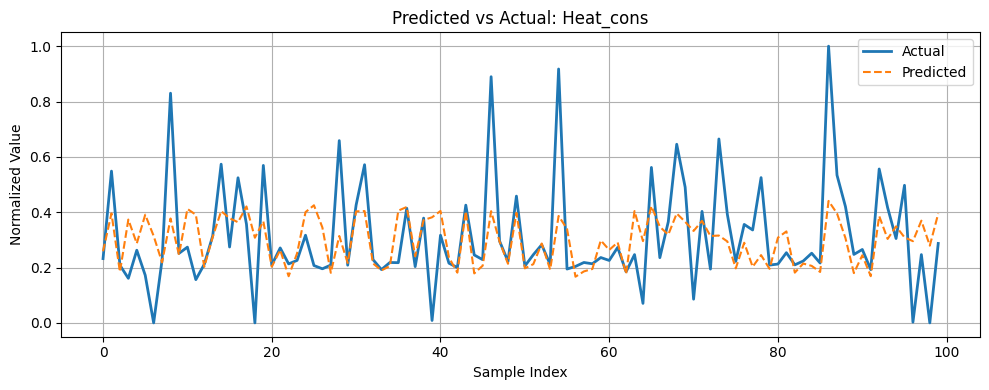

In [97]:
features = ["Heat_cons"]  # Chỉ có một feature trong trường hợp này
plot_feature_predictions(y_true_reshaped, y_pred_reshaped, features)


In [98]:
torch.save(model.state_dict(), "sensor_predictor.pth")

In [101]:
import torch
import torch.nn as nn

class GRUPredictor(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, dense_size=64, output_size=1, dropout=0.2):
        super(GRUPredictor, self).__init__()
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size1,
                           batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.gru2 = nn.GRU(input_size=hidden_size1, hidden_size=hidden_size2,
                           batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(hidden_size2, dense_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_size, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.gru1(x)         # (batch, seq_len, hidden1)
        out = self.dropout(out)
        out, _ = self.gru2(out)       # (batch, seq_len, hidden2)
        out = out[:, -1, :]           # Lấy output tại bước thời gian cuối (batch, hidden2)
        out = self.fc1(out)           # (batch, dense)
        out = self.relu(out)
        out = self.fc2(out)           # (batch, output_size)
        return out


In [102]:
model = GRUPredictor(input_size=7)  # input_size = số features

y_true, y_pred = train_model(model, train_loader, epochs=200)

Training on NVIDIA GeForce RTX 3060 Laptop GPU
Epoch 1/200, Loss: 0.0709, RMSE: 0.0829, R²: -1.3820
Epoch 2/200, Loss: 0.0324, RMSE: 0.0439, R²: -0.2614
Epoch 3/200, Loss: 0.0279, RMSE: 0.0353, R²: -0.0147
Epoch 4/200, Loss: 0.0302, RMSE: 0.0338, R²: 0.0279
Epoch 5/200, Loss: 0.0340, RMSE: 0.0351, R²: -0.0083
Epoch 6/200, Loss: 0.0239, RMSE: 0.0338, R²: 0.0302
Epoch 7/200, Loss: 0.0278, RMSE: 0.0321, R²: 0.0768
Epoch 8/200, Loss: 0.0544, RMSE: 0.0318, R²: 0.0870
Epoch 9/200, Loss: 0.0247, RMSE: 0.0309, R²: 0.1131
Epoch 10/200, Loss: 0.0336, RMSE: 0.0311, R²: 0.1059
Epoch 11/200, Loss: 0.0211, RMSE: 0.0301, R²: 0.1359
Epoch 12/200, Loss: 0.0432, RMSE: 0.0334, R²: 0.0407
Epoch 13/200, Loss: 0.0351, RMSE: 0.0300, R²: 0.1378
Epoch 14/200, Loss: 0.0463, RMSE: 0.0281, R²: 0.1927
Epoch 15/200, Loss: 0.0273, RMSE: 0.0294, R²: 0.1563
Epoch 16/200, Loss: 0.0320, RMSE: 0.0301, R²: 0.1339
Epoch 17/200, Loss: 0.0239, RMSE: 0.0268, R²: 0.2307
Epoch 18/200, Loss: 0.0582, RMSE: 0.0304, R²: 0.1261
Epoc

In [103]:
torch.save(model.state_dict(), "resource_predcitor_gru.pth")